In [1]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.main import FBRestNet
from FBResNet.model import MyModel
from FBResNet.posttreat import Export_hyper

In [2]:
exp1 = FBRestNet(experimentation=Physics(2000,50,1,1), constraint = 'slab',\
                 nb_blocks=20, noise = 0.01,\
                 folder = './', im_set="Set1",batch_size=[100,1],\
                 lr=1e-3, nb_epochs=[10,1])

In [3]:
train_set, val_set = exp1.CreateDataSet()

epoch :  0  -----  validation :  0.0043206040837421
epoch :  1  -----  validation :  0.004266093671145482
epoch :  2  -----  validation :  0.004192492848784296
epoch :  3  -----  validation :  0.0041573072556991865
epoch :  4  -----  validation :  0.004134601628527779
epoch :  5  -----  validation :  0.004004209232252007
epoch :  6  -----  validation :  0.00393303771191065
epoch :  7  -----  validation :  0.003828562158477408
epoch :  8  -----  validation :  0.003792706621232245
epoch :  9  -----  validation :  0.0037299978840482336
-----------------------------------------------------------------
Training is done.
-----------------------------------------------------------------


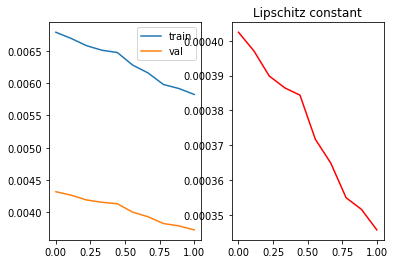

Final Lipschitz constant =  0.00034572670237430664


In [4]:
exp1.train(train_set,val_set,save_model=True)

### Gaussian

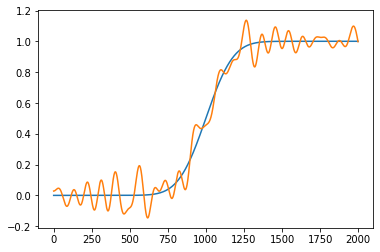

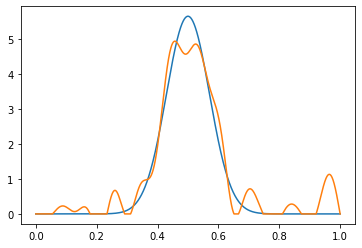

In [5]:
exp1.test_gauss()

### Lipschitz

In [6]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.04834056288345304

In [7]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

0.0008723620724288023

### Testing set

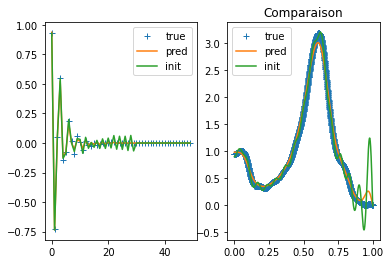

Erreur relative :  0.003913885934638792


In [8]:
l_i, l_t, l_p = exp1.test(val_set)

In [10]:
def test_gauss(self, noise = 0.01):
    # Gaussienne 
    nx    = self.physics.nx
    m     = self.physics.m
    fmax  = m//2
    t     = np.linspace(0,1,nx)
    gauss = np.exp(-(t-0.5)**2/(0.1)**(2))
    if self.constr == 'cube':
        gauss = gauss/np.amax(gauss)
    if self.constr == 'slab':
        u      = 1/nx**2*np.linspace(1,nx,nx)
        gauss = 0.5*gauss/np.dot(u,gauss)
    # export
    Export_Data(t,gauss,'./Redaction/data','gauss_'+self.constr)
    # obtenir les images bruitees par l' operateur d' ordre a
    # transform
    x_blurred  = self.physics.Compute(gauss).squeeze()
    yp         = self.physics.BasisChange(x_blurred)
    # Etape 4 : noise 
    vn          = np.zeros(m)
    vn[fmax//2:]= np.random.randn(m-fmax//2)
    vn          = noise*np.linalg.norm(yp)*vn/np.linalg.norm(vn)
    x_blurred_n = x_blurred + self.physics.BasisChangeInv(vn)
    # plot
    plt.plot(x_blurred)
    plt.plot(x_blurred_n)
    plt.show()
    # Etape 5 : bias
    x_b  = self.physics.ComputeAdjoint(x_blurred_n)
    # passage float tensor
    x_bias    = Variable(torch.FloatTensor(x_b.reshape(1,1,-1)),requires_grad=False)
    # definition of the initialisation tensor
    x_init   = torch.zeros(x_bias.shape)
    tTTinv   = MyMatmul(np.diag(self.physics.eigm**(2*self.physics.a)))
    x_init[:,:,:30] = tTTinv(x_bias)[:,:,:30] # filtration of high frequences
    x_init   = Variable(x_init.reshape(1,1,-1),requires_grad=False)
    # prediction
    x_pred   = self.model(x_init,x_bias)
    xpc      = x_pred.detach().numpy()[0,0,:]
    xp       = self.physics.BasisChangeInv(xpc)
    xp[xp<0] = 0
    # export
    Export_Data(t,xp,'./Redaction/data','gauss_pred_a{}_'.format(self.physics.a)+self.constr)
    # plot
    plt.plot(t,gauss)
    plt.plot(t,xp)
    # print("x/xb =",np.linalg.norm(x_b)/(1/np.sqrt(nx)*np.linalg.norm(gauss)))


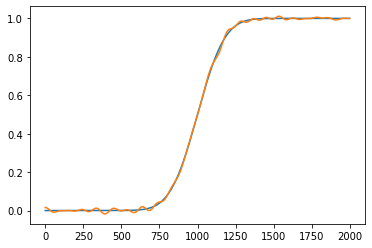

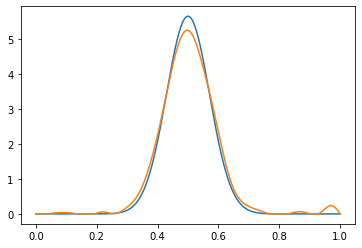

In [11]:
from FBResNet.posttreat import Export_Data
test_gauss(exp1)